In [7]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

from scipy import stats

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro


## Предобработка (часть 1)

In [8]:
def rename_cols(old_name, one_hot):
    new_cols = {}
    for column in one_hot:
        new_cols[column] = old_name + ": " + column
    return one_hot.rename(columns=new_cols)

In [9]:
def add_cols(df, add_df):
    for column in add_df.columns:
        df[column] = add_df[column]

In [10]:
def preprocessing(path):
    df = pd.read_csv(path)
    
    
    print(df.isnull().sum())
    # --- Ненужные для обработки столбцы --- 
    useles_columns = ['№', 'Модель (полное название)', 'Модель процессора', 'Год выпуска процессора', 'Модель встроенной видеокарты', 'Тип (марка) куллера материнской платы', 'Браузер для тестов','Исполнитель', 'Модель дискретной видеокарты']
    df = df.drop(labels = useles_columns,axis = 1)
    
    new_names = {'Объем видеопамяти (Гб)': 'Объем видеопамяти (Гб) [дискретной]',
                     'Объем видеопамяти (Гб).1': 'Объем видеопамяти (Гб) [встроенной]'}
    
    # --- Удаление NaN значений --- 
    df = df.rename(columns=new_names)
    df.dropna(subset=['Количество ядер',
      'Количество логических процессоров (потоков)',
      'Тактовая частота процессора (ГГц)',
      'Максимальная тактовая частота (ГГц)', 'Объем кэша L2 процессора (Кб)',
      'Объем кэша L3 процессора (Кб)', 'Размер оперативной памяти (Гб)',
      'Частота оперативной памяти (МГц)',
      'Учебный', 
      'Развлекательный', 
      'Эталон'],
      inplace=True)
    
    num_features = ['Количество ядер', 'Количество логических процессоров (потоков)', 'Тактовая частота процессора (ГГц)','HDD (Гб)','SSD(Гб)' , 'Объем видеопамяти (Гб) [встроенной]', 'Объем видеопамяти (Гб) [дискретной]']
    cat_features = ['Вид графического ускорителя (Дискретный / Встроенный)', 'Тип видеопамяти', 'Размер оперативной памяти (Гб)']

    # --- Обработка числовых значений --- 
    obj_df = df[num_features].copy()
    obj_df['Объем видеопамяти (Гб) [дискретной]'] = pd.to_numeric(obj_df['Объем видеопамяти (Гб) [дискретной]'], 
                                                                  errors='coerce')
    obj_df['Объем видеопамяти (Гб) [встроенной]'] = pd.to_numeric(obj_df['Объем видеопамяти (Гб) [встроенной]'], 
                                                                  errors='coerce')
    obj_df = obj_df.fillna({"Объем видеопамяти (Гб) [встроенной]": 0,
                     "Объем видеопамяти (Гб) [дискретной]": 0})
    df[num_features] = obj_df
    
    # --- Кодирование категориальных значений --- 
    
    # --- Вид графического ускорителя --- 
    graph_acc = pd.get_dummies(df['Вид графического ускорителя (Дискретный / Встроенный)'])
    graph_acc.head()
    graph_acc.columns = graph_acc.columns.str.strip()
    graph_acc.loc[graph_acc['дискретный и встроенный'] == 1, ['встроенный', 'дискретный']] = 1
    graph_acc = graph_acc.drop(['дискретный и встроенный', 'встроенный'], axis=1)
    graph_acc = rename_cols('Наличие графического ускорителя', graph_acc)
    graph_acc = graph_acc.fillna(0)
    
    # --- Тип видеопамяти --- 
    video_mem = pd.get_dummies(df['Тип видеопамяти'])
    video_mem = rename_cols('Тип видеопамяти', video_mem)
    
    # --- Размер оперативной памяти --- 
    RAM_size = (df['Размер оперативной памяти (Гб)'] // 8 > 0).astype(int)
    
    df = df.drop(cat_features, axis=1)
    add_cols(df, graph_acc)
    add_cols(df, video_mem)
    df['Оперативная память > 8'] = RAM_size
    
    # --- Сумма значений Бенчмарк --- 
    benchmark_columns = ['Учебный', 'Развлекательный', 'Эталон']
    benchmark_df = df[benchmark_columns].dropna()
    benchmark_df['sum'] = benchmark_df[benchmark_columns].sum(axis=1)
    df['benchmark'] = benchmark_df['sum']
    return df

In [11]:
df = preprocessing(r"data/laptop_info.csv")

№                                                         0
Модель (полное название)                                  0
Модель процессора                                         0
Год выпуска процессора                                    0
Количество ядер                                           0
Количество логических процессоров (потоков)               0
Тактовая частота процессора (ГГц)                         0
Максимальная тактовая частота (ГГц)                       0
Объем кэша L2 процессора (Кб)                             0
Объем кэша L3 процессора (Кб)                             0
Размер оперативной памяти (Гб)                            0
Частота оперативной памяти (МГц)                          0
HDD (Гб)                                                  0
SSD(Гб)                                                   0
Вид графического ускорителя (Дискретный / Встроенный)     0
Тип видеопамяти                                           0
Модель дискретной видеокарты            

In [12]:
df.head()

,Количество ядер,Количество логических процессоров (потоков),Тактовая частота процессора (ГГц),Максимальная тактовая частота (ГГц),Объем кэша L2 процессора (Кб),Объем кэша L3 процессора (Кб),Частота оперативной памяти (МГц),HDD (Гб),SSD(Гб),Объем видеопамяти (Гб) [дискретной],...,Развлекательный,Эталон,Наличие графического ускорителя: дискретный,Тип видеопамяти: DDR4,Тип видеопамяти: GDDR5,Тип видеопамяти: GDDR6,Тип видеопамяти: LPDDR4X,Тип видеопамяти: SMA,Оперативная память > 8,benchmark
0,6,12,3.0,4.0,3072,8192,3200,0,512,4.0,...,5082,5120,1.0,0,0,1,0,0,1,15278
1,2,4,2.2,3.4,512,4096,2133,0,128,0.0,...,2299,2743,0.0,0,0,0,0,1,0,7565
2,8,8,2.0,4.1,4096,8192,2667,0,512,0.0,...,4371,4565,0.0,1,0,0,0,0,1,13360
3,6,12,2.3,4.2,3072,16384,3200,0,512,0.0,...,5138,5204,0.0,1,0,0,0,0,1,15394
4,4,4,1.1,3.3,1536,4096,3200,0,256,0.0,...,2506,2561,0.0,1,0,0,0,0,1,7243


## Предобработка (часть 2)

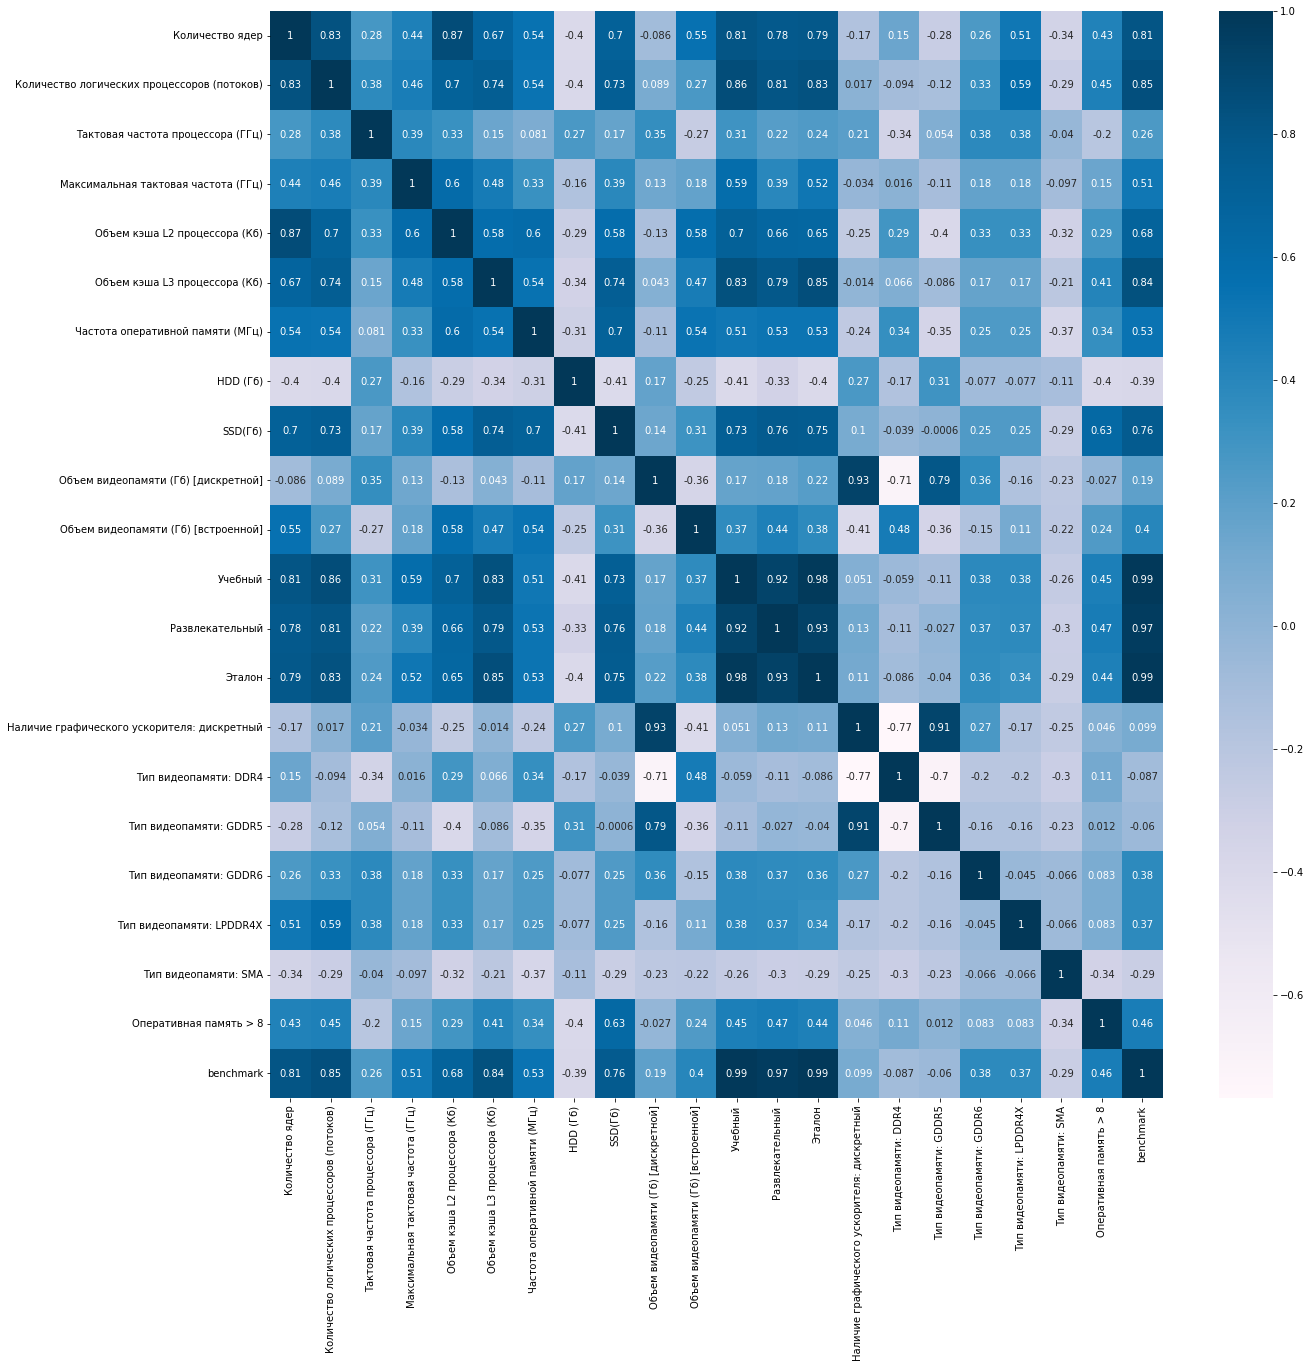

In [13]:
plt.figure(figsize=(20,20))  
p=sns.heatmap(df.corr(), annot=True,cmap =plt.cm.PuBu)

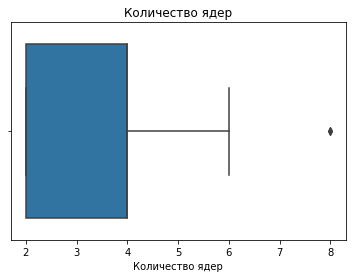

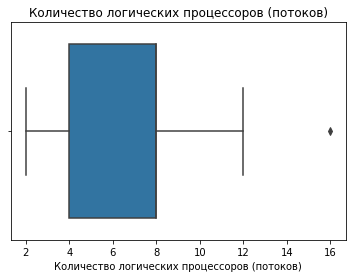

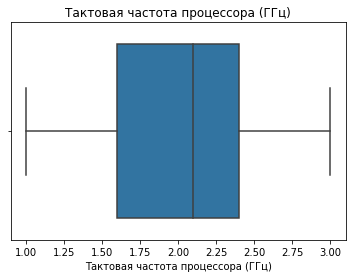

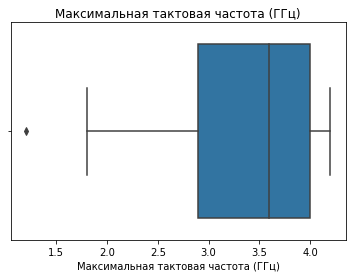

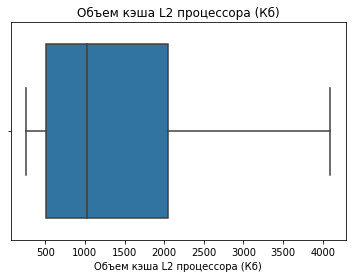

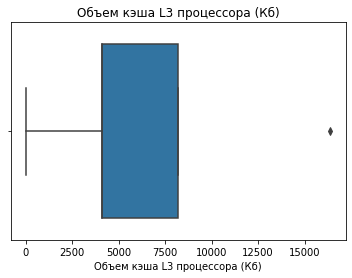

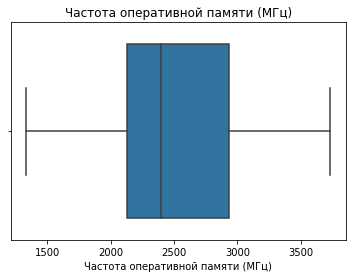

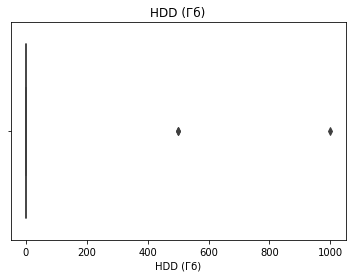

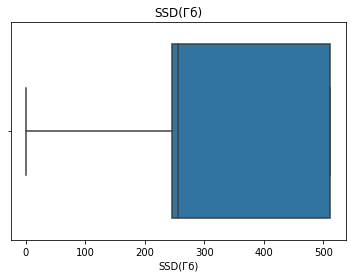

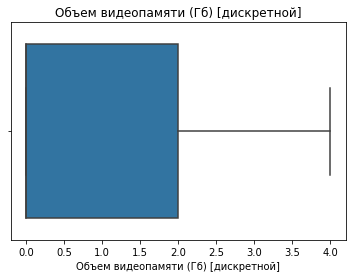

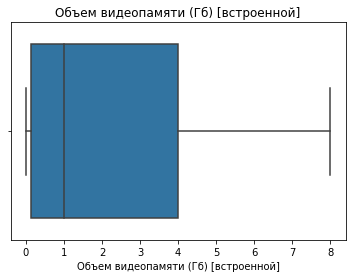

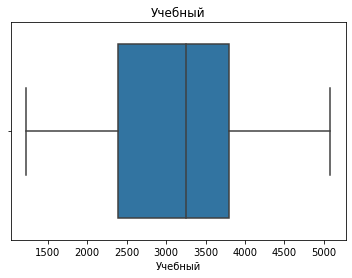

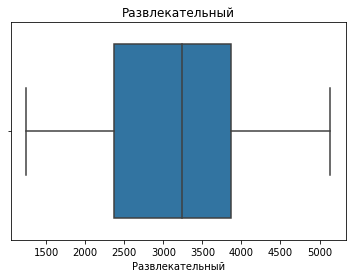

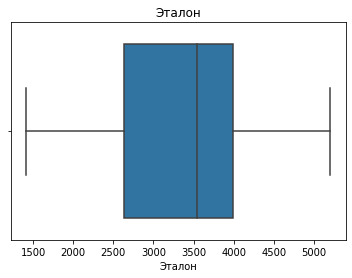

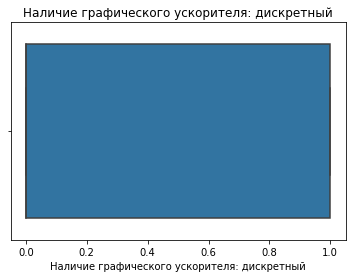

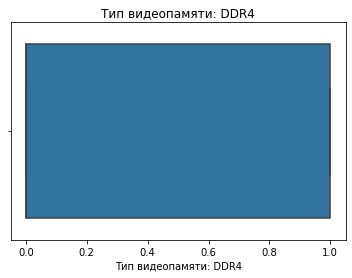

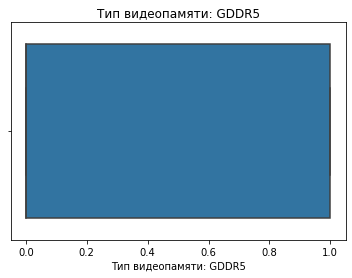

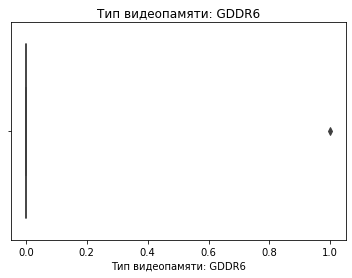

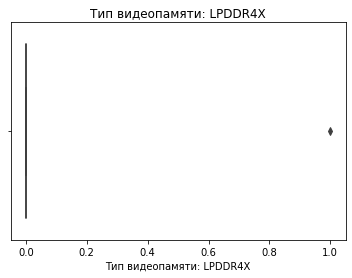

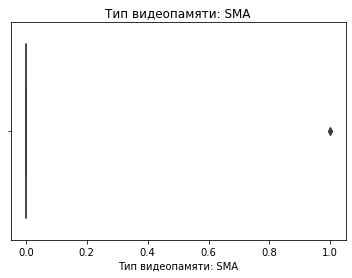

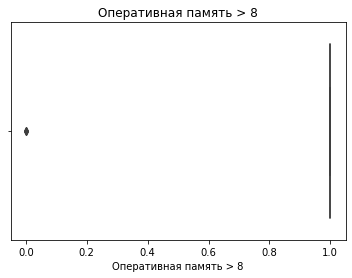

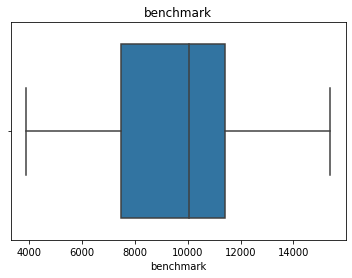

In [14]:
numeric_columns=df._get_numeric_data().columns

for col in numeric_columns:
    plt.title(col)
    sns.boxplot(df[col])
    plt.show()

In [15]:
# --- Итоговая проверка на наличие NaN значений --- 
df.isnull().sum()

Количество ядер                                0
Количество логических процессоров (потоков)    0
Тактовая частота процессора (ГГц)              0
Максимальная тактовая частота (ГГц)            0
Объем кэша L2 процессора (Кб)                  0
Объем кэша L3 процессора (Кб)                  0
Частота оперативной памяти (МГц)               0
HDD (Гб)                                       0
SSD(Гб)                                        0
Объем видеопамяти (Гб) [дискретной]            0
Объем видеопамяти (Гб) [встроенной]            0
Учебный                                        0
Развлекательный                                0
Эталон                                         0
Наличие графического ускорителя: дискретный    0
Тип видеопамяти: DDR4                          0
Тип видеопамяти: GDDR5                         0
Тип видеопамяти: GDDR6                         0
Тип видеопамяти: LPDDR4X                       0
Тип видеопамяти: SMA                           0
Оперативная память >

In [16]:
# --- Типы данных --- 
df.dtypes

Количество ядер                                  int64
Количество логических процессоров (потоков)      int64
Тактовая частота процессора (ГГц)              float64
Максимальная тактовая частота (ГГц)            float64
Объем кэша L2 процессора (Кб)                    int64
Объем кэша L3 процессора (Кб)                    int64
Частота оперативной памяти (МГц)                 int64
HDD (Гб)                                         int64
SSD(Гб)                                          int64
Объем видеопамяти (Гб) [дискретной]            float64
Объем видеопамяти (Гб) [встроенной]            float64
Учебный                                          int64
Развлекательный                                  int64
Эталон                                           int64
Наличие графического ускорителя: дискретный    float64
Тип видеопамяти: DDR4                            uint8
Тип видеопамяти: GDDR5                           uint8
Тип видеопамяти: GDDR6                           uint8
Тип видеоп

## Построение модели

In [17]:
def get_std_coefs(X, y):
    res = [0]
    X_z = sm.add_constant(X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore))
    Y_z = pd.DataFrame(y).apply(stats.zscore)
    model = sm.OLS(Y_z, X_z).fit()
    res.extend(model.params.tolist())
    return pd.Series(res)

In [18]:
def get_pivot(df, model, param, label, num):
    pivot_test = pd.DataFrame()
    predictors = model.params.index.tolist()
    n = len(predictors)
    i = np.ones(n).astype(int) * num
    pivot_test['id'] = pd.Series(i)
    pivot_test['predictors'] = predictors
    pivot_test['b'] = model.params.tolist()
    pivot_test['std_err'] = model.bse.tolist()
    influence = model.get_influence()
    pivot_test['std coef'] = get_std_coefs(df[param], df[label])
    pivot_test['t'] = model.tvalues.tolist()
    pivot_test['lower interval'] = model.conf_int(alpha=0.05)[:][0].tolist()
    pivot_test['upper interval'] = model.conf_int(alpha=0.05)[:][1].tolist()
    return pivot_test.set_index('id')

In [19]:
def get_model(df, label):
    labels = ['benchmark', 'Учебный', 'Развлекательный',
       'Эталон']
    X_data = df.drop(labels, axis=1)
    Y_data = df.drop(X_data.columns, axis=1)

    predictors = X_data.to_dict()
    sorted_predictors = sorted(predictors, key=lambda x: abs(X_data[x].corr(Y_data[label])))

    pred_list = []
    Y = Y_data[label]
    pivot_df = pd.DataFrame()
    i = 1
    for predictor in sorted_predictors:
        
        pred_list.append(predictor)
        X = sm.add_constant(df[pred_list])
        model = sm.OLS(Y, X).fit()
        F_crit = model.tvalues ** 2
        if F_crit[predictor] < 3.84:
            pred_list.pop()
        else:
            remove_list = list(F_crit[F_crit <= 2.71].index)
            for el in remove_list:
                if el in pred_list:
                    pred_list.remove(el)
        if len(pred_list) != 0:
            model_info = get_pivot(df, model, pred_list, label, i)
            pivot_df = pd.concat([pivot_df, model_info], axis=0)
            i += 1
            
    return model, pivot_df

In [20]:
labels = ['benchmark', 'Учебный', 'Развлекательный',
       'Эталон']
X_data = df.drop(labels, axis=1)
Y_data = df.drop(X_data.columns, axis=1)

In [21]:
label = 'benchmark'

In [22]:
predictors = X_data.to_dict()
sorted_predictors = sorted(predictors, key=lambda x: abs(X_data[x].corr(Y_data[label])))

In [23]:
for name in sorted_predictors:
    print(f"{name}: {abs(X_data[name].corr(Y_data[label]))}")

Тип видеопамяти: GDDR5: 0.060168149779711036
Тип видеопамяти: DDR4: 0.08651501683812594
Наличие графического ускорителя: дискретный: 0.09864273796544283
Объем видеопамяти (Гб) [дискретной]: 0.1925369649218771
Тактовая частота процессора (ГГц): 0.26078030576713157
Тип видеопамяти: SMA: 0.28698810636987365
Тип видеопамяти: LPDDR4X: 0.37237965055826777
Тип видеопамяти: GDDR6: 0.37659157215104855
HDD (Гб): 0.38751049550261263
Объем видеопамяти (Гб) [встроенной]: 0.4044057340064038
Оперативная память > 8: 0.4638003041976466
Максимальная тактовая частота (ГГц): 0.5086593229801025
Частота оперативной памяти (МГц): 0.5309294980641823
Объем кэша L2 процессора (Кб): 0.6833863419888858
SSD(Гб): 0.7608296485941649
Количество ядер: 0.8094026606958182
Объем кэша L3 процессора (Кб): 0.838638317545644
Количество логических процессоров (потоков): 0.847731729830222


In [24]:
pred_list = []
Y = Y_data[label]
pivot_df = pd.DataFrame()
i = 1
for predictor in sorted_predictors:
    
    pred_list.append(predictor)
    X = sm.add_constant(df[pred_list])
    model = sm.OLS(Y, X).fit()
    F_crit = model.tvalues ** 2
    if F_crit[predictor] < 3.84:
        pred_list.pop()
    else:
        remove_list = list(F_crit[F_crit <= 2.71].index)
        for el in remove_list:
            if el in pred_list:
                pred_list.remove(el)
    if len(pred_list) != 0:
        model_info = get_pivot(df, model, pred_list, label, i)
        pivot_df = pd.concat([pivot_df, model_info], axis=0)
        i += 1

In [25]:
pivot_df

,predictors,b,std_err,std coef,t,lower interval,upper interval
id,,,,,,,
1,const,8812.836132,813.863485,0.000000e+00,10.828396,7120.314360,10505.357904
1,Объем видеопамяти (Гб) [встроенной],431.989367,213.190406,1.387779e-16,2.026308,-11.364352,875.343086
2,const,6028.097839,1575.045066,0.000000e+00,3.827254,2742.611404,9313.584275
2,Объем видеопамяти (Гб) [встроенной],330.539939,205.354722,1.387779e-16,1.609605,-97.822504,758.902381
2,Оперативная память > 8,3499.662890,1733.647443,4.638003e-01,2.018670,-116.662305,7115.988086
3,const,1350.236708,2376.417856,0.000000e+00,0.568182,-3606.884076,6307.357492
3,Оперативная память > 8,3591.435072,1560.247437,1.387779e-16,2.301837,336.815949,6846.054194
3,Максимальная тактовая частота (ГГц),1642.032209,630.280832,3.982504e-01,2.605239,327.289432,2956.774986
4,const,-1093.030578,2700.105136,0.000000e+00,-0.404810,-6744.415576,4558.354421


In [26]:
pivot_df.loc[9]

,predictors,b,std_err,std coef,t,lower interval,upper interval
id,,,,,,,
9,const,3640.164169,715.220233,0.000000e+00,5.089571,2143.191017,5137.137321
9,Количество ядер,451.955526,298.992670,1.387779e-16,1.511594,-173.843324,1077.754375
9,Объем кэша L3 процессора (Кб),0.422377,0.134134,4.483488e-01,3.148915,0.141631,0.703123
9,Количество логических процессоров (потоков),295.141499,174.766187,5.374314e-01,1.688779,-70.648335,660.931332


In [27]:
model.params

const                                          3640.164169
Количество ядер                                 451.955526
Объем кэша L3 процессора (Кб)                     0.422377
Количество логических процессоров (потоков)     295.141499
dtype: float64

In [28]:
Y_data.columns

Index(['Учебный', 'Развлекательный', 'Эталон', 'benchmark'], dtype='object')

In [42]:
df.to_csv(r"data/puha_preprocessing.csv", index=False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Количество ядер                              23 non-null     int64  
 1   Количество логических процессоров (потоков)  23 non-null     int64  
 2   Тактовая частота процессора (ГГц)            23 non-null     float64
 3   Максимальная тактовая частота (ГГц)          23 non-null     float64
 4   Объем кэша L2 процессора (Кб)                23 non-null     int64  
 5   Объем кэша L3 процессора (Кб)                23 non-null     int64  
 6   Частота оперативной памяти (МГц)             23 non-null     int64  
 7   HDD (Гб)                                     23 non-null     int64  
 8   SSD(Гб)                                      23 non-null     int64  
 9   Объем видеопамяти (Гб) [дискретной]          23 non-null     float64
 10  Объе

## Функции для получения модели и ее сводной таблицы

In [29]:
def get_std_coefs(X, y):
    res = [0]
    X_z = sm.add_constant(X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore))
    Y_z = pd.DataFrame(y).apply(stats.zscore)
    model = sm.OLS(Y_z, X_z).fit()
    res.extend(model.params.tolist())
    return pd.Series(res)

In [30]:
def get_pivot(df, model, param, label, num):
    pivot_test = pd.DataFrame()
    predictors = model.params.index.tolist()
    n = len(predictors)
    i = np.ones(n).astype(int) * num
    pivot_test['id'] = pd.Series(i)
    pivot_test['predictors'] = predictors
    pivot_test['b'] = model.params.tolist()
    pivot_test['std_err'] = model.bse.tolist()
    influence = model.get_influence()
    pivot_test['std coef'] = get_std_coefs(df[param], df[label])
    pivot_test['t'] = model.tvalues.tolist()
    pivot_test['lower interval'] = model.conf_int(alpha=0.05)[:][0].tolist()
    pivot_test['upper interval'] = model.conf_int(alpha=0.05)[:][1].tolist()
    return pivot_test.set_index('id')

In [31]:
def get_model(df, label):
    labels = ['benchmark', 'Учебный', 'Развлекательный',
       'Эталон']
    X_data = df.drop(labels, axis=1)
    Y_data = df.drop(X_data.columns, axis=1)

    predictors = X_data.to_dict()
    sorted_predictors = sorted(predictors, key=lambda x: abs(X_data[x].corr(Y_data[label])))

    pred_list = []
    Y = Y_data[label]
    pivot_df = pd.DataFrame()
    i = 1
    for predictor in sorted_predictors:
        
        pred_list.append(predictor)
        X = sm.add_constant(df[pred_list])
        model = sm.OLS(Y, X).fit()
        F_crit = model.tvalues ** 2
        if F_crit[predictor] < 3.84:
            pred_list.pop()
        else:
            remove_list = list(F_crit[F_crit <= 2.71].index)
            for el in remove_list:
                if el in pred_list:
                    pred_list.remove(el)
        if len(pred_list) != 0:
            model_info = get_pivot(df, model, pred_list, label, i)
            pivot_df = pd.concat([pivot_df, model_info], axis=0)
            i += 1
            
    return model, pivot_df

## Построение моделей

In [32]:
bench_model, pivot_banch = get_model(df, 'benchmark')
ethalon_model, pivot_ethalon = get_model(df, 'Эталон')
learn_model, pivot_learn = get_model(df, 'Учебный')
fun_model, pivot_fun = get_model(df, 'Развлекательный')

## Тестирование модели

In [33]:
data_test = X

In [34]:
model = bench_model

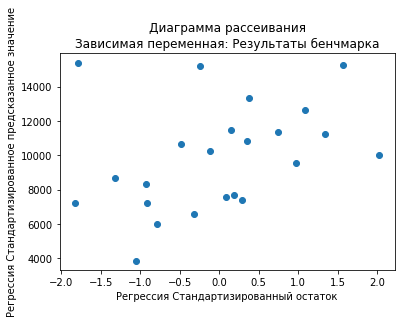

In [35]:
#Диаграмма рассеивания остатков
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
plt.scatter(standardized_residuals,df["benchmark"])
plt.title("Диаграмма рассеивания\nЗависимая переменная: Результаты бенчмарка")
plt.xlabel("Регрессия Стандартизированный остаток")
plt.ylabel("Регрессия Стандартизированное предсказанное значение")
None


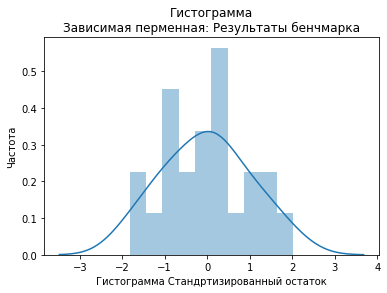

In [36]:
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
plt.title("Гистограмма\nЗависимая перменная: Результаты бенчмарка")
plt.xlabel("Гистограмма Стандртизированный остаток")
plt.ylabel("Частота")

sns.distplot(standardized_residuals, bins = 10)
None


In [37]:

#F - test
print("Тест RESET Рамсея")
ram = sm.stats.diagnostic.linear_reset(model, power=2, use_f = True)
# R^2
print("\nR =",sqrt(model.rsquared))
print("R^2 = ",model.rsquared)
print("Cкорректированный R^2=",model.rsquared_adj)

print("\nF - статистика = ",model.fvalue)
f_crit = stats.f.ppf(q = ram.pvalue, dfn=ram.df_num,dfd = ram.df_denom)
print("F критическое =",f_crit)



Тест RESET Рамсея

R = 0.915386418121805
R^2 =  0.837932294481868
Cкорректированный R^2= 0.8123426567684787

F - статистика =  32.74498466398517
F критическое = 0.15128115004696266


In [38]:

if model.fvalue <f_crit:
    print("Так как F - статистика < критического значения (",f_crit,"), Модель не правильно специфицирована")
else:
    print("Так как F - статистика >= критического значения (",f_crit,"), Модель правильно специфицирована")
    # VIF
    vif = pd.DataFrame()
    vif["predictors"] = model.params.index
    vif ["VIF values"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    print(vif)
    if max(vif["VIF values"])>=10:
        print("Присутствует мульиколлинеарность")
    else:
        print("Мультиколлинеарность не присутствует")
        dw = sm.stats.stattools.durbin_watson(model.resid)
        print("\nЗначение критерия Дурбина - Уотсона: ", dw)
        if abs(4 - dw) < abs(2 - dw):
            print("Отрицательная автокорреляция")
        elif dw < abs(2 - dw):
            print("Положительная автокорреляция")
        else:
            print("Остатки независимы")
            #print(model.summary())
            sh = shapiro(model.resid)
            print("\nЗначение критерия Шапиро", sh.statistic, "Значение коэффициента p", sh.pvalue)
            if sh.pvalue<0.05:
                print("Остатки не распределены нормально (p<0.05)")
            else:
                print("Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)")

Так как F - статистика >= критического значения ( 0.15128115004696266 ), Модель правильно специфицирована
                                    predictors  VIF values
0                                        const    6.501558
1                              Количество ядер    3.350641
2                Объем кэша L3 процессора (Кб)    2.246425
3  Количество логических процессоров (потоков)    4.033144
Мультиколлинеарность не присутствует

Значение критерия Дурбина - Уотсона:  1.5008920650436917
Остатки независимы

Значение критерия Шапиро 0.9843237400054932 Значение коэффициента p 0.9650726318359375
Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)
